# Imports

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import os, math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, silhouette_score
from sklearn.cluster import KMeans

# Loading Data

In [2]:
with open("options.txt", 'r') as f:
    options = f.readlines()
    options = {option.split("=")[0]: option.split("=")[1].strip() for option in options}
print(options)

{'hanoi_scenario_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\Hanoi_CMH\\Scenario-1', 'RUG_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\RUG_data_5years', 'RUG_raw_csv': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_csv.csv', 'RUG_timeseries': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_timeseries.pkl', 'RUG_obfuscated': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data.pkl'}


In [3]:
RUG = pd.read_pickle(r'C:\Users\Martin\Desktop\thesis 2\obfuscated_data_rm_outlier.pkl')

# Preparing and Transforming Data

In [4]:
RUG.interpolate(method='linear', inplace=True, limit=20)

In [5]:
def create_groups(data):
    data_copy = data.copy()
    groups = data_copy.groupby(pd.Grouper(freq='D'))

    # get the calender date of the groups
    days = list(groups.first().index.strftime('%Y:%m:%d'))

    gro = [groups.get_group(x).reset_index(drop=True) for x in groups.groups]

    temp = pd.concat(gro, axis=1, keys=days)

    temp.index = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')

    # drop all columns of temp dataframe which contain nan values
    temp.dropna(axis=1, how='any', inplace=True)

    return temp[::10]

In [6]:
def scale_data(data):
    data_copy = data.copy()
    train_percentage = 0.8
    train_size = int(len(data_copy.columns) * train_percentage)

    train = data_copy.iloc[:, :train_size]
    test = data_copy.iloc[:, train_size:]

    scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_list_train = [train[col] for col in train]
    scaled_list_train = scaler.fit_transform(scaled_list_train)
    
    scaled_list_test = [test[col] for col in test]
    scaled_list_test = scaler.transform(scaled_list_test)

    return scaled_list_train, scaled_list_test

In [7]:
def create_pca(data):
    data_copy = data.copy()
    
    pca = PCA(n_components=0.85, svd_solver='full')
    
    # Fit and transform data
    pca_features = pca.fit_transform(data_copy)

    return pca_features

In [8]:
def kmeans_sillouette(data):
    data_copy = data.copy()
    wcss = []
    silhouette_scores = []
    
    for i in range(1,10):
        print(i)
        kmeans_pca = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_jobs=-1).fit(data_copy)
        wcss.append(kmeans_pca.inertia_)
        try:
            silhouette_scores.append(silhouette_score(data_copy, kmeans_pca.labels_, n_jobs=-1))
        except:
            silhouette_scores.append(0)
    return wcss, silhouette_scores

In [9]:
def plot_scores(column, wcss, silhouette_scores):
    fig, ax1 = plt.subplots()
    x_scale = range(1,10)

    color = 'tab:red'
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('WCSS', color=color)
    ax1.plot(x_scale, wcss, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel('Silhouette score', color=color)  
    ax2.plot(x_scale, silhouette_scores, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title(column)
    fig.tight_layout()  
    plt.show()
    return

In [10]:
def elbow(column):
    grouped_data = create_groups(RUG[column])

    scaled_list_train, scaled_list_test = scale_data(grouped_data)

    pca_data = create_pca(scaled_list_train)

    wcss, silhouette_scores = kmeans_sillouette(pca_data)

    plot_scores(column, wcss, silhouette_scores)
    return (wcss, silhouette_scores)

In [11]:
all_wcss = []
all_silhouette_scores = []

Location 2 - consumption
1
2
3
4
5
6
7
8
9


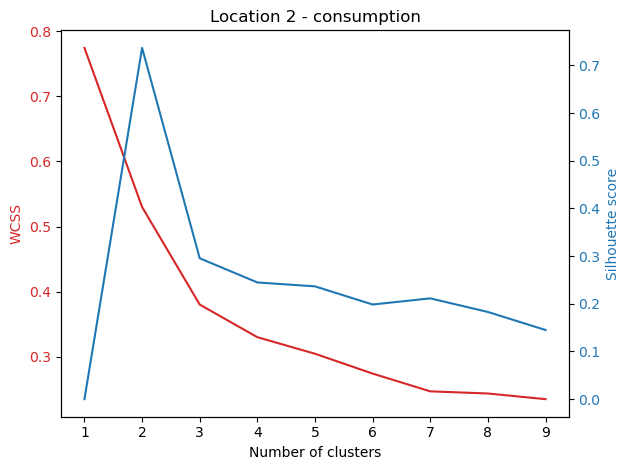

Location 3 - consumption
1
2
3
4
5
6
7
8
9


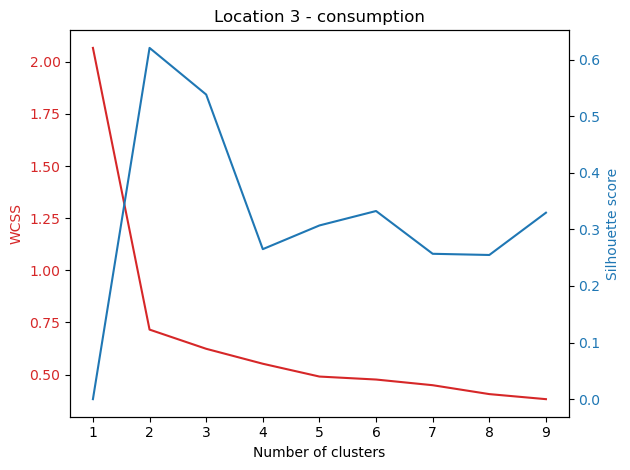

Location 11 - head
1
2
3
4
5
6
7
8
9


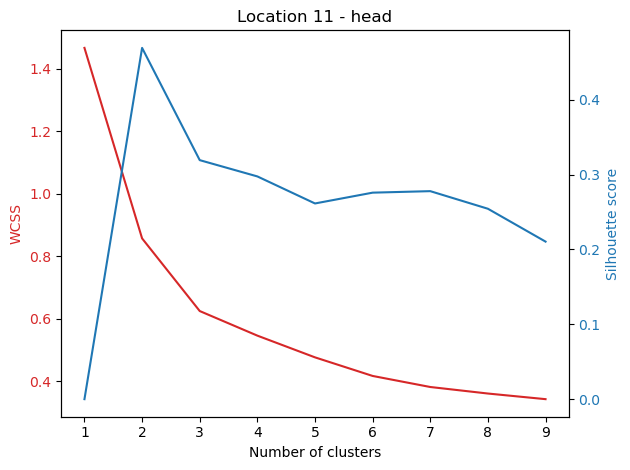

In [12]:
for location in RUG:
    if location not in ['Location 2 - consumption',
    'Location 3 - consumption','Location 11 - head']:
        continue
    print(location)
    scores = elbow(location)
    all_wcss.append(scores[0])
    all_silhouette_scores.append(scores[1])

Location 1 - flow
1
2
3
4
5
6
7
8
9


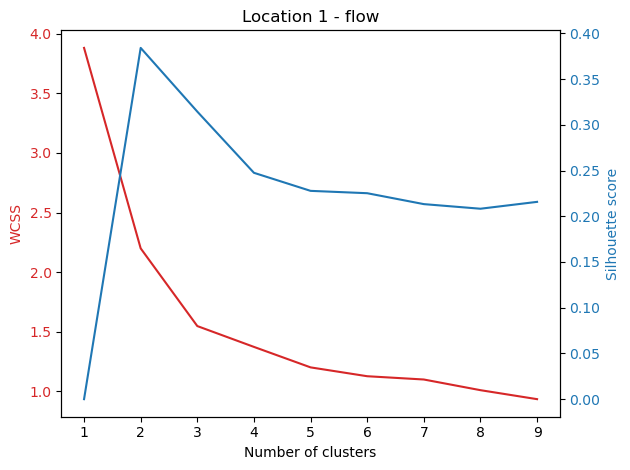

Location 2 - consumption
1
2
3
4
5
6
7
8
9


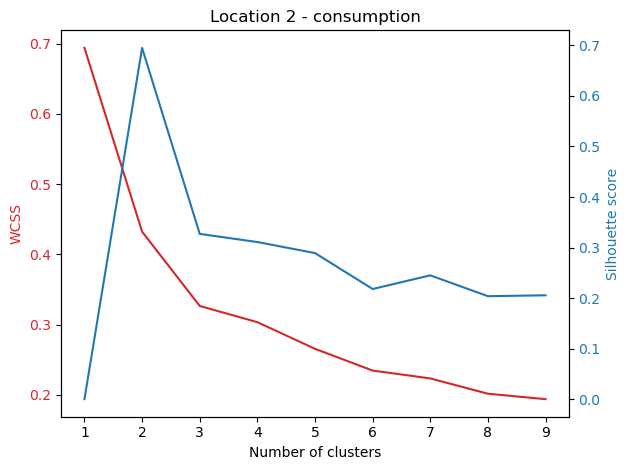

Location 3 - consumption
1
2
3
4
5
6
7
8
9


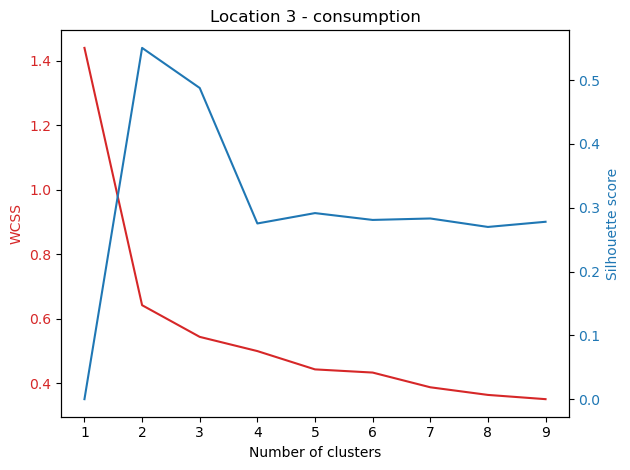

Location 4 - consumption
1
2
3
4
5
6
7
8
9


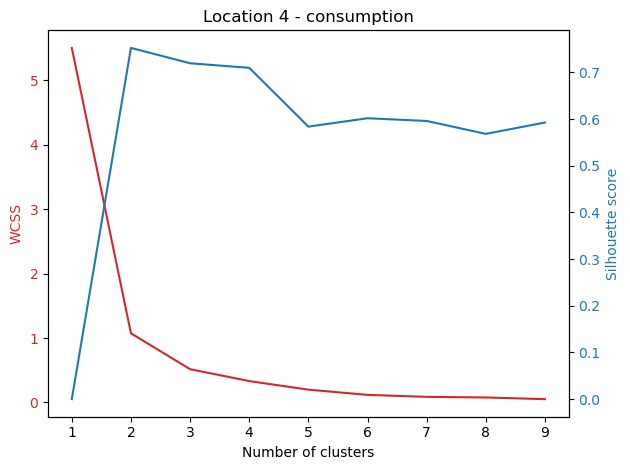

Location 5 - consumption
1
2
3
4
5
6
7
8
9


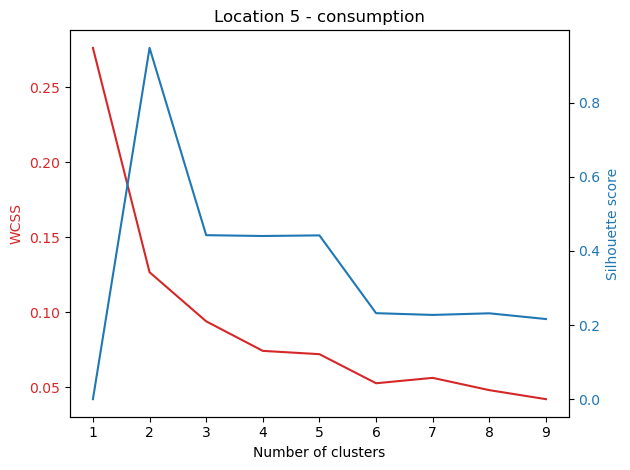

Location 6 - head
1
2
3
4
5
6
7
8
9


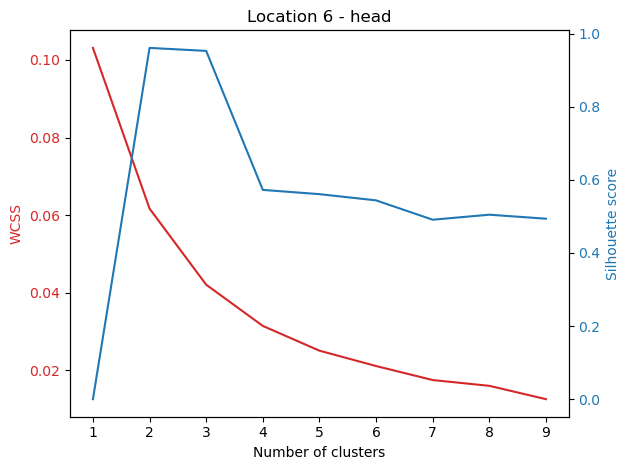

Location 7 - head
1
2
3
4
5
6
7
8
9


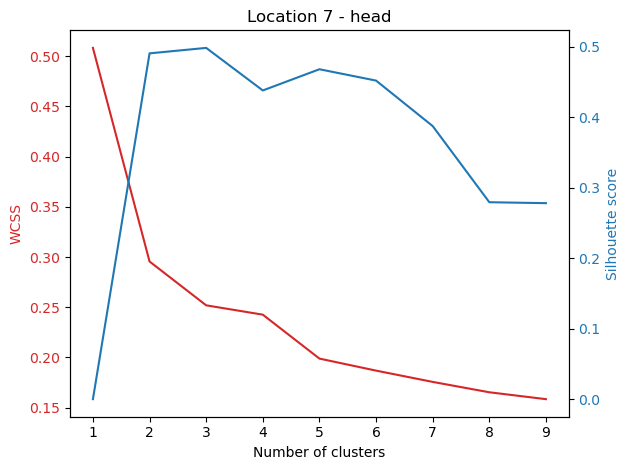

Location 8 - flow
1
2
3
4
5
6
7
8
9


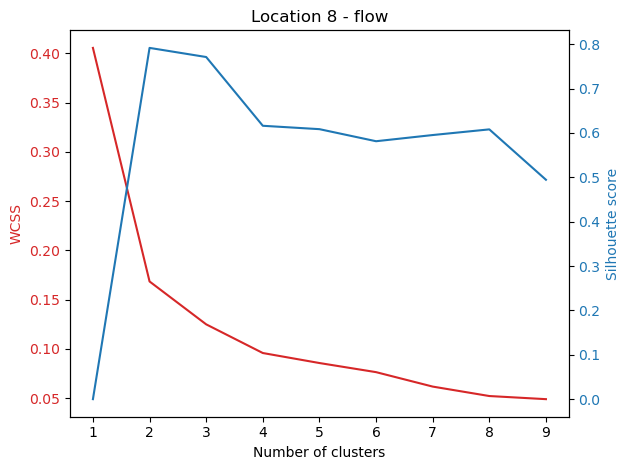

Location 9 - head
1
2
3
4
5
6
7
8
9


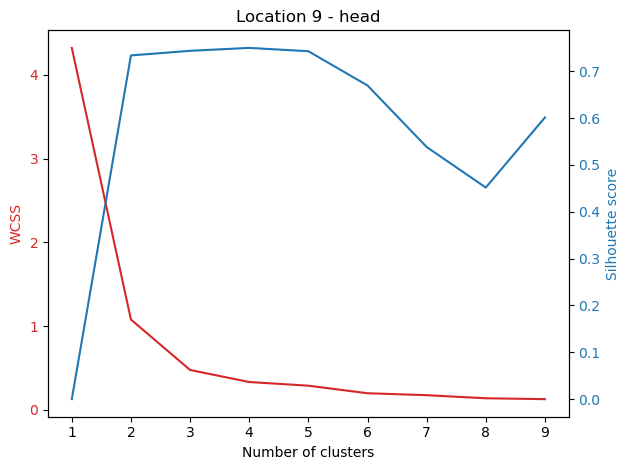

Location 10 - flow
1
2
3
4
5
6
7
8
9


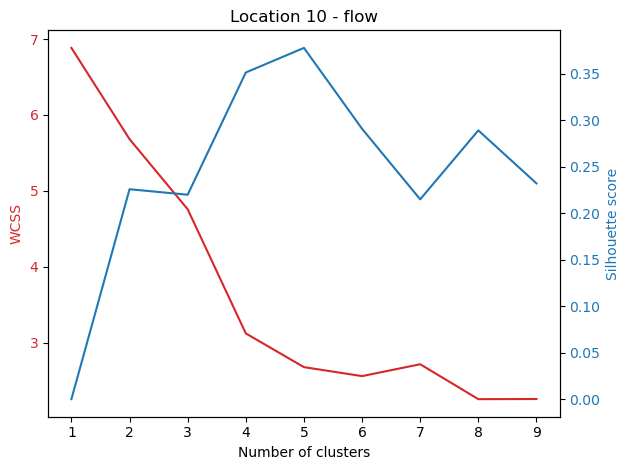

Location 11 - head
1
2
3
4
5
6
7
8
9


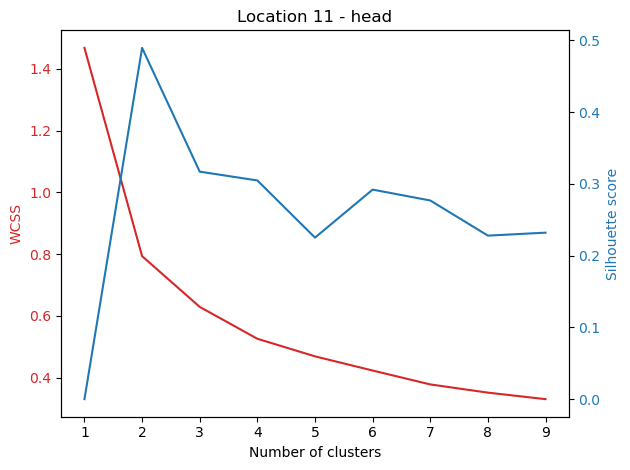

Location 11 - flow
1
2
3
4
5
6
7
8
9


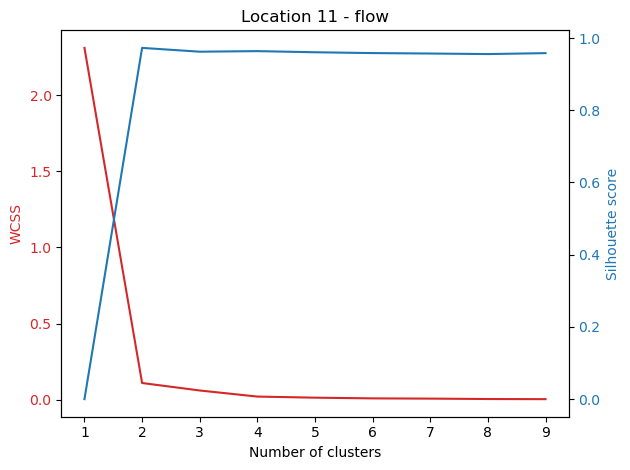

Location 12 - head
1
2
3
4
5
6
7
8
9


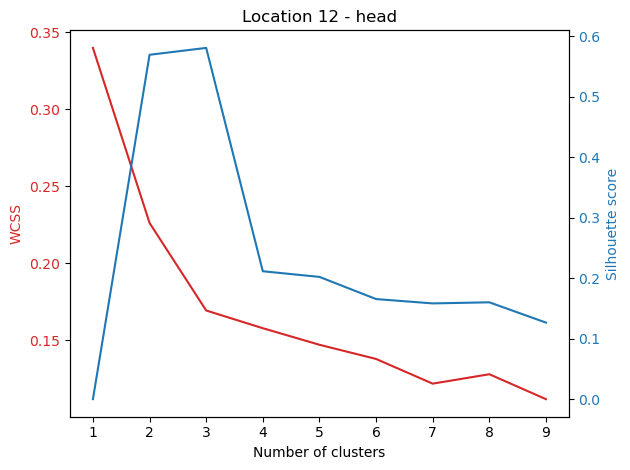

In [28]:
all_wcss = []
all_silhouette_scores = []

for column in RUG.columns:
    print(column)
    scores = elbow(column)
    all_wcss.append(scores[0])
    all_silhouette_scores.append(scores[1])

In [29]:
print(all_wcss)

[[3.8808251722533424, 2.1996956190660075, 1.5481127067788483, 1.3734729945414055, 1.2017163535876787, 1.12751987430967, 1.1000395538394938, 1.0105361295478803, 0.9352016132907766], [0.6939072643274243, 0.4323876974669721, 0.3266073810817046, 0.30351153525345065, 0.26559505570806924, 0.23464958156500995, 0.22345246525411253, 0.2016805472372478, 0.19394671495754448], [1.4405953171190051, 0.6423513651726133, 0.5440703683956315, 0.4999953922819792, 0.4432027536351408, 0.4333547740387387, 0.3876908516958832, 0.3640008780581925, 0.3508378641084842], [5.501272518762331, 1.0731191616527873, 0.5164203704228671, 0.33208251532396926, 0.19872671344796025, 0.11797775369620421, 0.08725572367888762, 0.07748616370728902, 0.05152906934344741], [0.27624811168017055, 0.1265982765845056, 0.09384789108342395, 0.07414067622621785, 0.07194356413174743, 0.05253794082776207, 0.056138820603067276, 0.04794023545367584, 0.04193046351547401], [0.10310357568224461, 0.061697141272031644, 0.04209274408642235, 0.03147

In [30]:
print(all_silhouette_scores)

[[0, 0.38407265491198783, 0.31439221458368927, 0.24749411769133303, 0.22775612087129538, 0.22518577517316132, 0.21325655071214017, 0.20822054570955212, 0.21572490806398753], [0, 0.695129706331859, 0.32707552971953996, 0.31091486801283247, 0.2891045281170488, 0.21797713661794746, 0.24500992486282003, 0.20377355818035434, 0.20554753022965033], [0, 0.5503820524733853, 0.4875731250131765, 0.27528693882679134, 0.2915344709176359, 0.28082861170841417, 0.2830916602976648, 0.2698404087337263, 0.2779356558594332], [0, 0.752520710920179, 0.7195889299376136, 0.7098364510356674, 0.5838662102529689, 0.6017948136982213, 0.5959933732234582, 0.5683022673578298, 0.5926238295362997], [0, 0.9473330616819029, 0.44226260954481633, 0.4400240902162946, 0.44169026991776805, 0.23191330778836608, 0.22715931477751408, 0.23152155093481006, 0.21610836588712953], [0, 0.9612637596942999, 0.9530163881918812, 0.5726849251303103, 0.5610145348584777, 0.5440086337637806, 0.4910492065343773, 0.5047881130776036, 0.49384531

In [24]:
all_wcss = [[3.9633222247305864, 2.1193511095491315, 1.6524573782381662, 1.3397443334713337, 1.2435149475293386, 1.157517581330189, 1.1140408916342341, 1.0001128123166638, 0.9089742531236015], [0.7145425180553637, 0.4300521257091938, 0.348129851137406, 0.28816431472985327, 0.26247385451630434, 0.23577676200396436, 0.21037863140161925, 0.21352049469091, 0.18775100334198372], [1.4241647254013532, 0.6399536938159381, 0.5664484345556301, 0.5043131618790818, 0.45013619728797566, 0.4253521007928447, 0.3855138509441154, 0.36582915251236886, 0.35047187232640625], [5.501272518762331, 1.0731191616527873, 0.5164203704228671, 0.353789299932636, 0.19872671344796025, 0.11797775369620421, 0.08701624199923272, 0.06440217762935717, 0.05152835659949158], [0.28216943731592997, 0.12387678507605837, 0.09932988931941977, 0.07423656826099008, 0.059280169835230045, 0.05306058193856195, 0.050007927403889464, 0.04719490609089972, 0.04077684316656376], [0.10344862795518327, 0.058891921371607515, 0.04820312434370645, 0.031008665266143987, 0.025616838245843015, 0.02110422370540548, 0.018049189638789237, 0.013834280257791993, 0.012765240524092069], [0.498488976896352, 0.3025466027348706, 0.2527015363378645, 0.21407262201064195, 0.2023787475449225, 0.18511240747993274, 0.17699387060657956, 0.16289679159087164, 0.16225496136827564], [0.39146166136272953, 0.1684872260755145, 0.1258823945999117, 0.10635822713213089, 0.08248247430974351, 0.06966100634364734, 0.0662988039493201, 0.05407316187240495, 0.05345503335422418], [4.32359877108337, 1.078967909866386, 0.4764880216572293, 0.33263692940149914, 0.28876496492022385, 0.22889335071136202, 0.17545203264093143, 0.14186465962563197, 0.12857188640703113], [7.110103818295909, 4.907789386195483, 3.8614258125839687, 3.1446224826516302, 2.736781244561164, 2.520355922311285, 2.4748121027412657, 2.2824303571553894, 2.1968931634866404], [1.4066518505626138, 0.8361370178750477, 0.6284745039577232, 0.5291551501759576, 0.4464109488947513, 0.40372037310511144, 0.36390937990216465, 0.33767315931404746, 0.32747459771891696], [2.3093807060404137, 0.11016862406337548, 0.0611007870050975, 0.02108997608901667, 0.014104466156811317, 0.009104895367249694, 0.006473475574165577, 0.005380956685005749, 0.004212173800712137], [0.3334942130677379, 0.22968040030107992, 0.20272329469174669, 0.14890384723664593, 0.13954389482001583, 0.13671163079667514, 0.12351998850798768, 0.12197986884972294, 0.1106046899302626]]
all_silhouette_scores = [[0, 0.38383592676635164, 0.3100041524538657, 0.248844241258555, 0.2268882313466648, 0.20953430065850345, 0.21074298285303275, 0.23199727466050174, 0.2281279266685377], [0, 0.7009102607218379, 0.3296030718735929, 0.32398136592868526, 0.26405341918334796, 0.2659631993362225, 0.22065140246370107, 0.16211541802166493, 0.16417929513070442], [0, 0.5494300713545633, 0.37319162922207233, 0.46504157036797616, 0.3397073589937618, 0.2540510154795411, 0.2829888101486346, 0.27134742969037756, 0.2743959183651376], [0, 0.752520710920179, 0.7195889299376136, 0.6547965146953074, 0.5838662102529689, 0.6017948136982213, 0.5984834327214588, 0.5941444508274495, 0.5925047283960798], [0, 0.9473330616819029, 0.9392476304922864, 0.44190770889104725, 0.35324698029090673, 0.23229734035002067, 0.23143968046794428, 0.23149557186903474, 0.19466974130208067], [0, 0.9612637596942999, 0.7480906156020836, 0.5683940734225065, 0.567676673833603, 0.5120350360938266, 0.5901272160600144, 0.5072238050651939, 0.37487915235364166], [0, 0.4904425556953889, 0.4972478561718773, 0.48231573738670863, 0.27143030655232114, 0.4697790942904361, 0.46858740673080296, 0.2734886807861783, 0.26892038453499295], [0, 0.7916426826704457, 0.7789466204425384, 0.5997707807470152, 0.6089465329594369, 0.6169830723430395, 0.48291137898331177, 0.4890269963763995, 0.4828403826217433], [0, 0.7338847224671582, 0.7437238223748248, 0.7500278887114963, 0.7428935054879788, 0.5777748735280698, 0.5383467155770197, 0.6776534746600127, 0.6031024049684477], [0, 0.5417785663215758, 0.3370588973276842, 0.3706421503254471, 0.30817414118429187, 0.28436957186752965, 0.2858385885542624, 0.27079568428541506, 0.2890382545993724], [0, 0.3867611084729981, 0.3241361744215299, 0.28927141224213665, 0.2666559845653372, 0.2782447228030957, 0.2133740662399786, 0.23889099156646834, 0.2286726560587243], [0, 0.9726831071305294, 0.9621564548845519, 0.963770631099565, 0.9631762693402661, 0.9575875678807575, 0.9567222145729453, 0.9572215127181449, 0.9561160624625986], [0, 0.5681558761376287, 0.2234965844100605, 0.21511759658212884, 0.21951903169909381, 0.11829502414644524, 0.1619346445940471, 0.14656364099341998, 0.12590572386263477]]

